# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [39]:
from bs4 import BeautifulSoup
import requests
import sqlite3
import matplotlib.pyplot as plt

import pandas as pd

# Define the URL
url = "https://ycharts.com/companies/TSLA/revenues"

# Set up more headers to mimic a browser
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept-Language": "en-US,en;q=0.9",
    "Accept-Encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
    "DNT": "1"  # Do Not Track request header
}

# Use a session to maintain cookies and headers across requests
session = requests.Session()
session.headers.update(headers)

In [45]:
# Send the GET request with the session
response = session.get(url)

# Check if the request was successful
if response.status_code == 200:
    html_content = response.text
    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Find all tables
    tables = soup.find_all('table')
    
    # The first table is the relevant one
    quarterly_table = tables[0]

    # Extract headers
    headers = [header.text for header in quarterly_table.find_all('th')]

    # Extract rows
    rows = []
    for row in quarterly_table.find_all('tr'):
        cells = row.find_all('td')
        if len(cells) > 0:  # Skip headers
            row_data = [cell.text.strip() for cell in cells]
            rows.append(row_data)
            
else:
    print("Failed to retrieve the webpage. Status code:", response.status_code)

In [46]:
# Create a DataFrame
df = pd.DataFrame(rows, columns=headers)

# Verify by printing the DataFrame
print(df)

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Convert 'Value' column to float
df['Value'] = df['Value'].replace({'B': ''}, regex=True).astype(float)

df.drop(columns=['Value'])

# Create an empty SQLite database and connect to it
conn = sqlite3.connect('tesla_revenue.db')
cursor = conn.cursor()


                  Date   Value
0        June 30, 2024  25.50B
1       March 31, 2024  21.30B
2    December 31, 2023  25.17B
3   September 30, 2023  23.35B
4        June 30, 2023  24.93B
5       March 31, 2023  23.33B
6    December 31, 2022  24.32B
7   September 30, 2022  21.45B
8        June 30, 2022  16.93B
9       March 31, 2022  18.76B
10   December 31, 2021  17.72B
11  September 30, 2021  13.76B
12       June 30, 2021  11.96B
13      March 31, 2021  10.39B
14   December 31, 2020  10.74B
15  September 30, 2020  8.771B
16       June 30, 2020  6.036B
17      March 31, 2020  5.985B
18   December 31, 2019  7.384B
19  September 30, 2019  6.303B
20       June 30, 2019   6.35B
21      March 31, 2019  4.541B
22   December 31, 2018  7.226B
23  September 30, 2018  6.824B
24       June 30, 2018  4.002B


In [47]:

# Create the table
cursor.execute('''
    CREATE TABLE IF NOT EXISTS revenue (
        date TEXT,
        value REAL
    )
''')
conn.commit()

# Insert the values
for index, row in df.iterrows():
    cursor.execute('''
        INSERT INTO revenue (date, value)
        VALUES (?, ?)
    ''', (row['Date'].strftime('%Y-%m-%d'), row['Value']))
conn.commit()

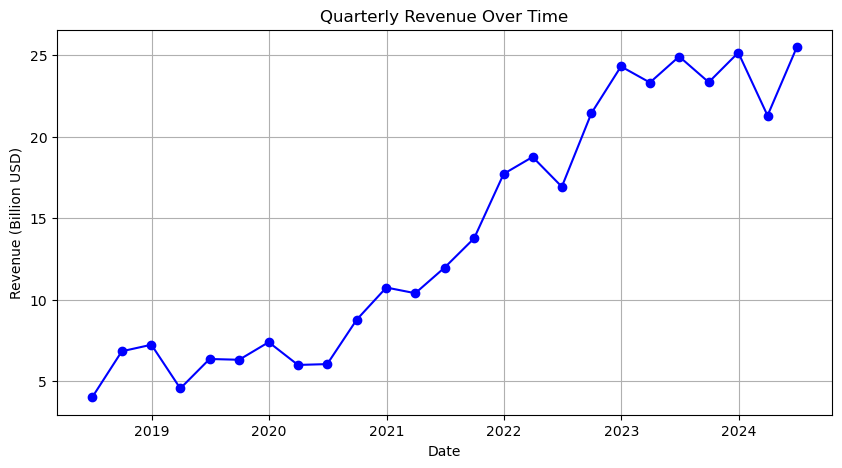

In [48]:
# Close the connection
conn.close()

# Line plot for revenue over time
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Value'], marker='o', linestyle='-', color='b')
plt.title('Quarterly Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue (Billion USD)')
plt.grid(True)
plt.show()


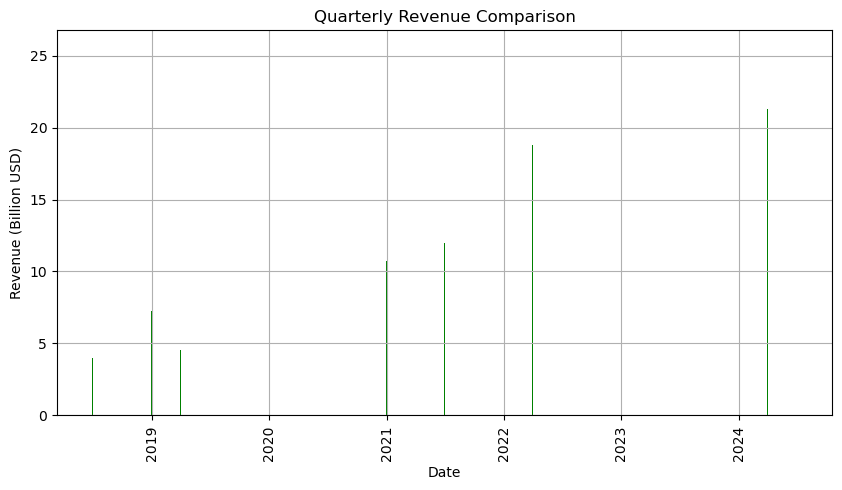

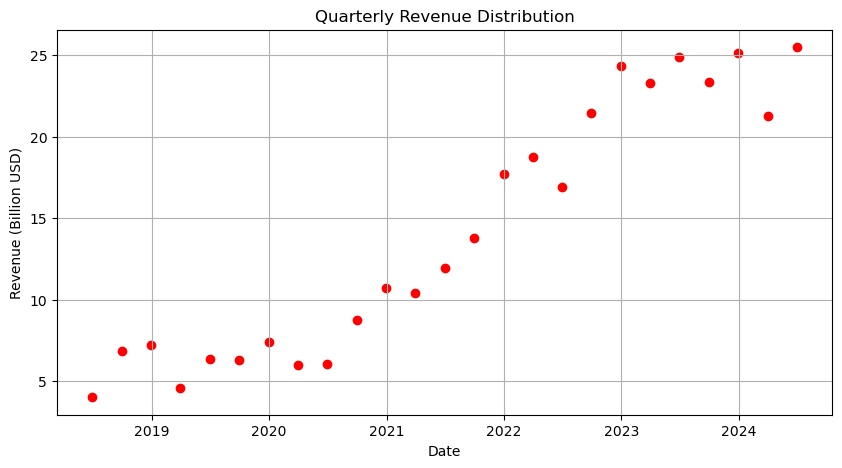

In [49]:
# Bar plot for revenue comparison
plt.figure(figsize=(10, 5))
plt.bar(df['Date'], df['Value'], color='green')
plt.title('Quarterly Revenue Comparison')
plt.xlabel('Date')
plt.ylabel('Revenue (Billion USD)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Scatter plot for revenue distribution
plt.figure(figsize=(10, 5))
plt.scatter(df['Date'], df['Value'], color='red')
plt.title('Quarterly Revenue Distribution')
plt.xlabel('Date')
plt.ylabel('Revenue (Billion USD)')
plt.grid(True)
plt.show()